<a href="https://colab.research.google.com/github/ariaberlian/rbm_sr/blob/main/rbm_sr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# !git clone https://github.com/albertbup/deep-belief-network.git
# !pip install -r "deep-belief-network/requirements.txt"
# !mv "deep-belief-network" "deep_belief_network"
# !pip install pydicom

# """
# - add this to dbn/tensorflow/models.py:
#     import tensorflow._api.v2.compat.v1 as tf
#     tf.disable_v2_behavior()
# """

In [4]:
import numpy as np
import cv2
import os
import pydicom
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.fftpack import dct, idct
from sklearn.preprocessing import MinMaxScaler
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from matplotlib import gridspec
from __future__ import print_function

print(__doc__)

import numpy as np

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.pipeline import Pipeline
from deep_belief_network.dbn.tensorflow.models import UnsupervisedDBN # use "from dbn.tensorflow import SupervisedDBNClassification" for computations on TensorFlow

Automatically created module for IPython interactive environment


Instructions for updating:
non-resource variables are not supported in the long term


## Dicom Reader

In [5]:
# def read_dicom_images(directory):
#     dicom_images = []

#     # Loop melalui semua file dalam direktori
#     for filename in os.listdir(directory):
#         filepath = os.path.join(directory, filename)

#         # Cek apakah file adalah file DICOM
#         if os.path.isfile(filepath) and filename.lower().endswith('.dcm'):
#             # Baca file DICOM
#             dicom_data = pydicom.read_file(filepath)

#             # Ambil array gambar dari data DICOM
#             dicom_image_array = dicom_data.pixel_array

#             # Konversi ke format yang dapat diolah oleh OpenCV
#             dicom_image_array = dicom_image_array.astype('uint8')

#             dicom_images.append(dicom_image_array)

#     return np.array(dicom_images, dtype='object')

## Downscaler

In [6]:
# # Downscaling Image
# import cv2

# def downscale_image(image, scale_factor):
#     # Menggunakan resize dari OpenCV
#     width = int(image.shape[1] * scale_factor)
#     height = int(image.shape[0] * scale_factor)
#     dim = (width, height)
#     resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
#     return resized_image

# scale_factor = 0.5  # Ganti dengan faktor skala yang diinginkan

# # Baca gambar
# input_image = read_dicom_images("/content/drive/MyDrive/lung_ul_dcm")
# # print(input_image.size)
# # Downscale gambar
# x = 0
# for image in input_image:
#     resized_image = downscale_image(image.astype('uint8'), scale_factor)
#     # resized_image = image.astype('uint8')

#     # Simpan gambar hasil downscale
#     cv2.imwrite(f'/content/drive/MyDrive/lung_ul/ul_{x}.png', resized_image)
#     x += 1


## Image loader

In [7]:
def load_image(file_path):
    # Muat gambar
    image_cv2 = cv2.imread(file_path)
    img = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
    return img

## Interpolation

In [8]:
def interpolate(original_image, interpolation_factor):
  """
  Interpolasi bicubic gambar dengan skala interpolation_factor
  """
  # Interpolasi untuk memperbesar gambar
  enlarged_image = cv2.resize(original_image, None, fx=interpolation_factor, fy=interpolation_factor, interpolation=cv2.INTER_CUBIC)

  # Normalisasi
  enlarged_image = enlarged_image / 255.0

  return enlarged_image

# plt.imshow(interpolate(X_train[0], 2.0))
# plt.show()

## Visualizer

In [9]:
def visualize_histogram(original_image, normalized_image):
    plt.figure(figsize=(12, 6))

    # Histogram Sebelum Normalisasi
    plt.subplot(2, 2, 1)
    plt.hist(original_image.flatten(), bins=256, range=(0, 256), color='b', alpha=0.5)
    plt.title('Histogram Before Normalization')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    # Histogram Sesudah Normalisasi
    plt.subplot(2, 2, 2)
    plt.hist(normalized_image.flatten(), bins=256, range=(0, 1), color='r', alpha=0.5)
    plt.title('Histogram After Normalization')
    plt.xlabel('Normalized Value')
    plt.ylabel('Frequency')

    # Plot Gambar Asli
    plt.subplot(2, 2, 3)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')

    # Plot Hasil Normalisasi
    plt.subplot(2, 2, 4)
    plt.imshow(normalized_image, cmap='gray')
    plt.title('Normalized Image')

    plt.tight_layout()
    plt.show()

def visualize_patches(patches, visualize_size: tuple = (8,8)):
    # visualize patches example
    fig = plt.figure(figsize=(16, 16))
    plt.suptitle('Patches Example', fontsize=16)  # Menambahkan judul
    grid = gridspec.GridSpec(visualize_size[0], visualize_size[1], wspace=0.2, hspace=0.2)

    for i in range(visualize_size[0]):
        for j in range(visualize_size[1]):
            # Mengambil patch image
            patch = patches[i * visualize_size[0] + j]

            # Menampilkan patch image tanpa skala
            ax = plt.subplot(grid[i, j])
            ax.imshow(patch)
            ax.axis('off')  # Menyembunyikan sumbu

    plt.show()

def visualize_image(image, title):
    plt.imshow(image)
    plt.title(title)
    plt.show()

## Pre DBN

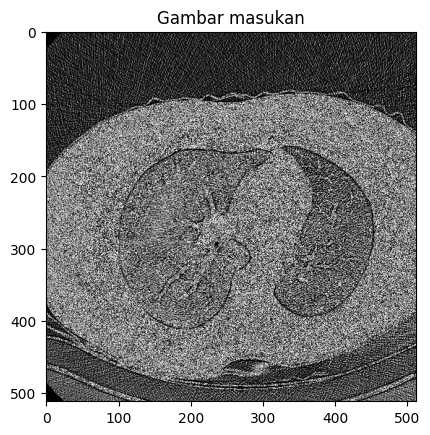

Jumlah Patches =  15625
this is the image:
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0 

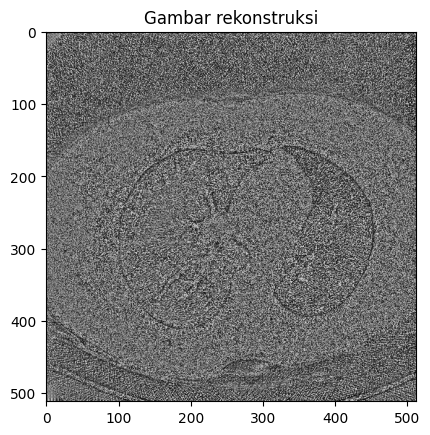

In [28]:
class DataProcessing:
    def __init__(self):
      # Inisialisasi dan fit-transform dengan MinMaxScaler
      self.scaler = MinMaxScaler()
      self.min_val = 0
      self.max_val = 0

    def _dct2(self, image):
        """
        Melakukan transformasi DCT 2D pada gambar.
        """
        return dct(dct(image, axis=0, norm='ortho'), axis=1, norm='ortho')

    def _idct2(self, coefficients):
        """
        Melakukan transformasi invers DCT 2D pada koefisien DCT.
        """
        return idct(idct(coefficients, axis=0, norm='ortho'), axis=1, norm='ortho')

    def _normalize_for_rbm(self, image):
        """
        Normalisasi gambar untuk dapat dimasukkan ke dalam Restricted Boltzmann Machine (RBM).
        """
        # Lakukan transformasi DCT 2D pada setiap saluran
        dct_coefficients_channels = [self._dct2(image[:, :, c]) for c in range(image.shape[2])]

        # Gabungkan koefisien DCT dari setiap saluran
        dct_coefficients = np.stack(dct_coefficients_channels, axis=-1)
        # print("DCT coeff: ", dct_coefficients)

        # Inisialisasi dan fit-transform dengan MinMaxScaler
        # Reshape ke bentuk 2D untuk scaler
        flattened_dct_coefficients = dct_coefficients.reshape(-1, image.shape[2])
        normalized_data = self.scaler.fit_transform(flattened_dct_coefficients)

        # Reshape kembali ke bentuk asli setelah normalisasi
        normalized_dct_coefficients = normalized_data.reshape(dct_coefficients.shape)

        # Simpan nilai minimum dan maksimum sebelum normalisasi
        self.min_val = self.scaler.data_min_
        self.max_val = self.scaler.data_max_

        return normalized_dct_coefficients

    def _zigzag(self, input):
        #initializing the variables
        #----------------------------------
        h = 0
        v = 0

        vmin = 0
        hmin = 0

        vmax = input.shape[0]
        hmax = input.shape[1]
        channel = input.shape[2]

        #print(vmax ,hmax, channel )

        i = 0

        output = np.zeros(( vmax * hmax * channel ))
        #----------------------------------

        while ((v < vmax) and (h < hmax)):
            #print(output)
            #print(f"{v}, {h}")
            if ((h + v) % 2) == 0:                 # going up
                if (v == vmin):
                    #print(1)
                    for c in range(channel):
                        output[i+c] = input[v, h, c]        # if we got to the first line
                    i = i + channel - 1
                    if (h == hmax-1):
                        #print("chihuy")
                        v = v + 1
                    else:
                        h = h + 1

                    i = i + 1

                elif ((h == hmax -1 ) and (v < vmax)):   # if we got to the last column
                    #print(2)
                    for c in range(channel):
                        output[i+c] = input[v, h, c]
                    i = i + channel - 1
                    v = v + 1
                    i = i + 1

                elif ((v > vmin) and (h < hmax -1 )):    # all other cases
                    #print(3)
                    for c in range(channel):
                        output[i+c] = input[v, h, c]
                    i = i + channel - 1
                    v = v - 1
                    h = h + 1
                    i = i + 1
            else:                                    # going down

                if ((v == vmax -1) and (h <= hmax -1)):       # if we got to the last line
                    #print(4)
                    for c in range(channel):
                        output[i+c] = input[v, h, c]
                    i = i + channel - 1
                    h = h + 1
                    i = i + 1

                elif (h == hmin):                  # if we got to the first column
                    #print(5)
                    for c in range(channel):
                        output[i+c] = input[v, h, c]
                    i = i + channel -1

                    if (v == vmax -1):
                        h = h + 1
                    else:
                        v = v + 1

                    i = i + 1

                elif ((v < vmax -1) and (h > hmin)):     # all other cases
                    #print(6)
                    for c in range(channel):
                        output[i+c] = input[v, h, c]
                    i = i + channel - 1
                    v = v + 1
                    h = h - 1
                    i = i + 1

            if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
                #print(7)
                for c in range(channel):
                    output[i+c] = input[v, h, c]
                i = i + channel - 1
                break

        ##print ('v:',v,', h:',h,', i:',i)
        return output

    # Inverse zigzag scan of a matrix
    # Arguments are: a 1-by-m*n array,
    # where m & n are vertical & horizontal sizes of an output matrix.
    # Function returns a two-dimensional matrix of defined sizes,
    # consisting of input array items gathered by a zigzag method.
    #
    # Matlab Code:
    # Alexey S. Sokolov a.k.a. nICKEL, Moscow, Russia
    # June 2007
    # alex.nickel@gmail.com

    def _inverse_zigzag(self, input, original_shape:tuple):

        ##print input.shape

        # initializing the variables
        #----------------------------------
        h = 0
        v = 0

        vmin = 0
        hmin = 0

        vmax, hmax, channel = original_shape

        output = np.zeros((vmax, hmax, channel))

        i = 0
        #----------------------------------

        while ((v < vmax) and (h < hmax)):
            ##print ('v:',v,', h:',h,', i:',i)
            if ((h + v) % 2) == 0:                 # going up

                if (v == vmin):
                    ##print(1)
                    for c in range(channel):
                        output[v, h, c] = input[i+c]        # if we got to the first line
                    i = i + channel-1
                    if (h == hmax-1):
                        v = v + 1
                    else:
                        h = h + 1

                    i = i + 1

                elif ((h == hmax -1 ) and (v < vmax)):   # if we got to the last column
                    ##print(2)
                    for c in range(channel):
                        output[v, h, c] = input[i+c]        # if we got to the first line
                    i = i + channel-1
                    v = v + 1
                    i = i + 1

                elif ((v > vmin) and (h < hmax -1 )):    # all other cases
                    ##print(3)
                    for c in range(channel):
                        output[v, h, c] = input[i+c]        # if we got to the first line
                    i = i + channel-1
                    v = v - 1
                    h = h + 1
                    i = i + 1

            else:                                    # going down

                if ((v == vmax -1) and (h <= hmax -1)):       # if we got to the last line
                    ##print(4)
                    for c in range(channel):
                        output[v, h, c] = input[i+c]        # if we got to the first line
                    i = i + channel-1
                    h = h + 1
                    i = i + 1

                elif (h == hmin):                  # if we got to the first column
                    ##print(5)
                    for c in range(channel):
                        output[v, h, c] = input[i+c]        # if we got to the first line
                    i = i + channel-1
                    if (v == vmax -1):
                        h = h + 1
                    else:
                        v = v + 1
                    i = i + 1

                elif((v < vmax -1) and (h > hmin)):     # all other cases
                    for c in range(channel):
                        output[v, h, c] = input[i+c]
                    i = i + channel-1
                    v = v + 1
                    h = h - 1
                    i = i + 1

            if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
                ##print(7)
                for c in range(channel):
                    output[v, h, c] = input[i+c]        # if we got to the first line
                i = i + channel-1
                break

        return output

    def preprocess_for_rbm(self, image):
        """
        Persiapkan data untuk dimasukkan ke dalam RBM.
        Image di normalisasi dengan dct sehingga dalam domain frekuensi dengan rentang [0,1]

        Input: patch image
        Output: flatten array
        """

        # Normalisasi gambar untuk RBM
        normalized_coefficients = self._normalize_for_rbm(image)

        # Flattening hasil untuk masukan RBM
        flattened_dct_coefficients = self._zigzag(normalized_coefficients)

        return flattened_dct_coefficients

    def inverse_preprocess(self, coefficients, original_shape):
        """
        Mengembalikan inverse koefisien DCT yang dinormalisasi ke gambar asli dengan inverse langkah zigzag
        """

        # Reshape ke bentuk yang sesuai dengan gambar asli
        reshaped_coefficients = self._inverse_zigzag(coefficients, original_shape)

        # Denormalisasi nilai koefisien
        denormalized_coefficients = self.scaler.inverse_transform(reshaped_coefficients.reshape(-1, original_shape[2]))

        # Reshape kembali ke bentuk asli setelah normalisasi
        denormalized_coefficients = denormalized_coefficients.reshape(original_shape)

        # Lakukan transformasi invers DCT 2D pada setiap saluran
        inverse_images = np.round([self._idct2(denormalized_coefficients[:, :, c]) for c in range(original_shape[2])])

        # Gabungkan hasil inverse DCT dari setiap saluran
        image = np.stack(inverse_images, axis=-1)

        return image.astype(np.uint8)

    def get_patches(self, input_image: np.ndarray, patch_size: tuple = (16,16), stride: tuple = (4,4)):
        """
        Ambil patch dari input_image dengan ukuran patch_size dan langkah sejauh stride
        """
        patches = []

        i = j = 0
        height, width, channels = input_image.shape[0], input_image.shape[1], input_image.shape[2]


        while i + patch_size[0] <= height:
          j = 0
          while j + patch_size[1] <= width:
            if i + patch_size[0] <= height and j + patch_size[1] <= width:
              patches.append(input_image[i:i+patch_size[0], j:j+patch_size[1], :])
            j += stride[1]
          i += stride[0]

        print("Jumlah Patches = ", len(patches))
        patches = np.asarray(patches).reshape(-1, patch_size[0], patch_size[1], channels)
        # visualize_patches(patches, (8,8))
        return np.asarray(patches).reshape(-1, patch_size[0], patch_size[1], channels)

    def reconstruct_from_patches(self, patches, original_shape, patch_size=(16, 16), stride=(4, 4)):
        """
        Rekonstruksi gambar utuh dari patches.
        """
        height, width, channels = original_shape
        num_rows = (height - patch_size[0]) // stride[0] + 1
        num_cols = (width - patch_size[1]) // stride[1] + 1

        reconstructed_image = np.zeros((height, width, channels), dtype=np.float64)
        count_matrix = np.zeros((height, width, channels), dtype=np.float64)

        patch_idx = 0
        for i in range(num_rows):
            for j in range(num_cols):
                start_row, start_col = i * stride[0], j * stride[1]
                end_row, end_col = start_row + patch_size[0], start_col + patch_size[1]
                reconstructed_image[start_row:end_row, start_col:end_col, :] += patches[patch_idx]
                count_matrix[start_row:end_row, start_col:end_col, :] += 1
                patch_idx += 1

        # Normalisasi dengan membagi dengan jumlah kontribusi setiap patch
        reconstructed_image /= count_matrix

        return reconstructed_image.astype(np.uint8)  # Pastikan tipe data akhir sesuai dengan kebutuhan

dp = DataProcessing()
true_image = load_image('/content/drive/MyDrive/lung1/2.png')
visualize_image(true_image, "Gambar masukan")

patches = dp.get_patches(true_image)

prep = []
for patch in patches:
  prep.append(dp.preprocess_for_rbm(patch))
print("this is the image:")
print(patches[0])

print("this is ready to rbm array:")
print(prep[0])

after = []
for p in prep:
  after.append(dp.inverse_preprocess(p, (16,16,3)))

print("this is inverse image:")
print(after[0])


recons = dp.reconstruct_from_patches(after, (512,512,3))

visualize_image(recons, "Gambar rekonstruksi")


## DBN

### Training

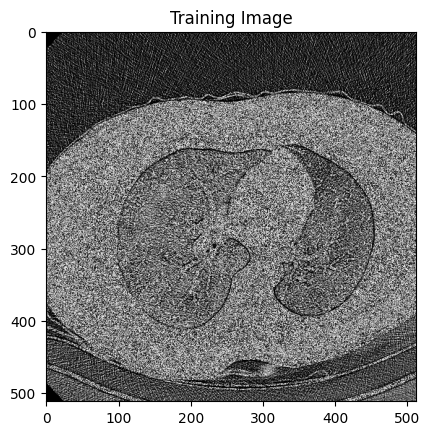

Jumlah Patches =  15625


KeyboardInterrupt: ignored

In [13]:
# Load Data
highres = load_image('/content/drive/MyDrive/lung1/0.png')

dp = DataProcessing()

visualize_image(highres, "Training Image")

patches_train = dp.get_patches(highres)

X_train = []

for patch_train in patches_train:
  X_train.append(dp.preprocess_for_rbm(patch_train))

X_train = np.asarray(X_train, dtype=np.ndarray).astype(float)

In [12]:
def proccess_output(u, r, beta, s):
  I = len(u)
  for i in range(I):
    if i>=(I/s):
      u[i] = beta*r[i]
  return u
# ###############################################################################
interpolation_factor = 2
beta = 1.5
Q = 2
lr = 0.01
epoch = 100
layers = [400,200,768]
batch_size = 128
activation_function = 'sigmoid'

# Models we will use
dbn = UnsupervisedDBN(hidden_layers_structure=layers,
                      batch_size=batch_size,
                      learning_rate_rbm=lr,
                      n_epochs_rbm=epoch,
                      activation_function=activation_function)


# ###############################################################################
# Training RBM
# q = 1
# dbn.fit(X_train)
# dbn.save("model_1.h5")
# while q < Q:
#   print("q saat ini: ", q)
#   dbn = dbn.load(f"model_{q}.h5")
#   r = dbn.transform(X_train)
#   X_train = proccess_output(X_train, r, beta, interpolation_factor)
#   dbn.fit(X_train)
#   dbn.save(f"model_{q+1}.h5")
#   q += 1


Instructions for updating:
Use `tf.cast` instead.


[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 1.694151
>> Epoch 2 finished 	RBM Reconstruction error 1.281858
>> Epoch 3 finished 	RBM Reconstruction error 1.228272
>> Epoch 4 finished 	RBM Reconstruction error 1.203959


KeyboardInterrupt: ignored

### Testing

In [ ]:
# # Testing
# dp1 = DataProcessing()
# dp2 = DataProcessing()

# lowres = load_image('/content/drive/MyDrive/lung0.5/2.png')
# true_image = load_image('/content/drive/MyDrive/lung1/2.png')

# # plt.imshow(true_image)
# # plt.show()

# interpolated_lowres = interpolate(lowres, interpolation_factor)
# lowpatch = get_patches(interpolated_lowres)

# patches_test = get_patches(true_image)

# X_test = []
# for patch_test in patches_test:
#   X_test.append(dp1.preprocess_for_rbm(patch_test))

# X_test = np.asarray(X_test, dtype=np.ndarray).astype(float)

# X_low = []
# for paci in lowpatch:
#   X_low.append(dp2.preprocess_for_rbm(paci))

# X_low = np.asarray(X_low, dtype=np.ndarray).astype(float)

# print("X_test max value: ", np.max(X_test))
# print("X_test min value: ", np.min(X_test))
# print("dp1 max: ", dp1.max_val)
# print("dp1 min: ", dp1.min_val)

# print("X_low max value: ", np.max(X_low))
# print("X_low min value: ", np.min(X_low))
# print("dp2 max: ", dp2.max_val)
# print("dp2 min: ", dp2.min_val)

# # dbn = dbn.load(f"model_{Q}.h5")
# # predicted_patch = dbn.transform(X_test)

# patches = []
# for p in X_test:
#   patches.append(dp1.inverse_preprocess(p, (16, 16, 3)))
# patches = np.asarray(patches, dtype=np.ndarray).astype(np.float64)

# plow = []
# for p in X_low:
#   plow.append(dp2.inverse_preprocess(p, (16, 16, 3)))
# plow = np.asarray(plow, dtype=np.ndarray).astype(np.float64)

# print("Patch max value: ", np.max(patches))
# print("Patch min value: ", np.min(patches))
# print("Plow max value: ", np.max(plow))
# print("Plow min value: ", np.min(plow))


# result = dp1.reconstruct_from_patches(patches, (512, 512, 3))
# print("Result max value: ", np.max(result))
# print("Result min value: ", np.min(result))

# reslow = dp2.reconstruct_from_patches(plow, (512, 512, 3))
# print("Reslow max value: ", np.max(reslow))
# print("Reslow min value: ", np.min(reslow))

# plt.imshow(result)
# plt.show()

# plt.imshow(reslow)
# plt.show()

### Scoring

In [ ]:
# Scoring
def calculate_psnr(original_image, enhanced_image):
    psnr_value = peak_signal_noise_ratio(original_image, enhanced_image)
    return psnr_value

def calculate_ssim(original_image, enhanced_image):
    # Inisialisasi variabel untuk menyimpan nilai SSIM untuk setiap channel
    ssim_values = []

    # Iterasi melalui setiap channel
    for channel in range(original_image.shape[2]):
        # Hitung SSIM untuk setiap channel
        ssim_channel, _ = structural_similarity(original_image[:, :, channel], enhanced_image[:, :, channel], full=True)

        # Tambahkan nilai SSIM ke dalam list
        ssim_values.append(ssim_channel)

    # Hitung rata-rata SSIM untuk semua channel
    average_ssim = np.mean(ssim_values)

    return average_ssim

print("PSNR value: ", calculate_psnr(result, reslow))
print("SSIM value: ", calculate_ssim(result, reslow))